# Household energy consumption forecast
#### *- Leveraging Amazon Forecast API -*
---

Previously, we leveraged the Amazon Forecast console to predict household energy consumption. We are now going to leverage the high level APIs from this service to achieve the same: **this notebook takes approximately an hour to run.**

The overall process for using Amazon Forecast is the following:

1. Create a **Dataset Group**, this is the large box that isolates models and the data they are trained on from each other. You can see that as an independant forecasting "project".
1. Create a **Dataset**: in Forecast there are 3 types of dataset, *Target Time Series*, *Related Time Series*, and *Item Metadata*. The *Target Time Series* is required, the others provide additional context that certain algorithms can leverage.
1. **Import data**, this moves the information from S3 into a storage volume where the data can be used for training and validation. You can see this as the ingestion process into the Forecast dataset.
1. **Train a model**, Forecast automates this process for you but you can also select particular algorithms, and you can provide your own hyper parameters or use Hyper Parameter Optimization (HPO) to determine the most performant values for your data.
1. **Deploy a Predictor**, here you are deploying your model so you can use it to generate a forecast.
1. **Query the Forecast**, given a request bounded by time for an item, return the forecast for it. Once you have this you can evaluate its performance or use it to guide your decisions about the future.

In this notebook we will be walking through the first 3 steps outlined above. One additional task that will be done here is to trim part of our training and validation data so that we can measure the accuracy of a forecast against our predictions.

## Table Of Contents
* **Preparation:**
  * Setup
  * Data Preparation
  * Creating the Dataset Group and Dataset
* **Building a predictor:**
  * Create a Predictor
  * Deploy a Predictor
  * Obtain a Forecast
* **Evaluating your forecast:** now is the time to pull down the predictions from this Predictor, and compare them to the actual observed values:
  * Obtaining a Prediction
  * Plotting the Actual Results
  * Plotting the Prediction
  * Comparing the Prediction to Actual Results
* **Cleanup:** after building completing the notebooks you may want to delete the following to prevent any unwanted charges:
  * Forecasts
  * Predictors
  * Datasets
  * Dataset Groups

For more informations about Amazon Forecast APIs, please check the [documentation](https://docs.aws.amazon.com/forecast/latest/dg/what-is-forecast.html)

# Preparation
---

## IAM role and authorizations
For the purpose of this sample, you need to make sure this SageMaker instance has the following authorizations:
* `IAMFullAccess`
* `AmazonForecastFullAccess`
* `AmazonS3FullAccess`
* `AmazonSageMakerFullAccess`

Browse to the IAM Console and check that the role your SageMaker instance runs with if configured like this:

![Datasets](pictures/iam-policy.png)

The **PassRole** policy visible above is configured as an inline policy:

```json
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Action": [
                "iam:PassRole"
            ],
            "Effect": "Allow",
            "Resource": "*"
        }
    ]
}
```

Last but not least, also make sure that the **trust relationships** of this same role includes at least the following:

![Datasets](pictures/iam-trust-relationship.png)

You can click on the **Edit trust relationship** button as seen on the picture above and fill in the following JSON document:
```json
{
    "Version": "2012-10-17",
    "Statement": [{
        "Effect": "Allow",
        "Principal": {
            "Service": [
                "sagemaker.amazonaws.com",
                "forecast.amazonaws.com",
                "s3.amazonaws.com"
            ]
        },
        "Action": "sts:AssumeRole"
    }]
}
```

## Setup

Import the standard Python libraries that are used in this lesson.

In [1]:
import boto3
import botocore.exceptions
import dateutil.parser
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sagemaker
import sys
import time

from sagemaker import get_execution_role

%matplotlib inline
plt.style.use('Solarize_Light2')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

The next part of the setup process is to validate that your account can communicate with Amazon Forecast, the cell below does just that. We also configure the S3 bucket name and region name for this notebook:
- If you don't have an S3 bucket, create it first on S3 or use the default bucket attached to this notebook
- Although we have set the region to eu-west-1 as a default value below, you can choose any of the regions that the service is available in.

In [2]:
BUCKET = sagemaker.Session().default_bucket()
PREFIX = 'forecast-workshop'
region = 'eu-west-1'

session = boto3.Session(region_name=region) 
forecast = session.client(service_name='forecast') 
forecastquery = session.client(service_name='forecastquery')
role = get_execution_role()

In [3]:
# Paths to local data:
DATA = 'data'
PROCESSED_DATA = 'data/processed'

os.makedirs(PROCESSED_DATA, exist_ok=True)

## Data Preparation
In the Data ingestion & EDA notebook, we already stored the hourly consumption of our households in a CSV file, we will load it here and prepare an appropriate input for Forecast. To begin, use Pandas to read the CSV and to show a sample of the data.

In [5]:
hourly_df = pd.read_csv(os.path.join(DATA, 'electricityusagedata.csv'), header=None, parse_dates=[0])
hourly_df.columns = ['timestamp', 'energy', 'client_id']
hourly_df = hourly_df.set_index('timestamp')
hourly_df.head()

,energy,client_id
timestamp,,
2014-01-01 01:00:00,23.648649,client_1
2014-01-01 01:00:00,0.000000,client_2
2014-01-01 01:00:00,144.817073,client_3
2014-01-01 01:00:00,75.000000,client_4
2014-01-01 01:00:00,266.369048,client_5


Notice in the output above there are 3 columns of data:

1. The **Timestamp** (timestamp)
1. A **Value** (energy)
1. An **Item** (client_id)

These are the 3 key required pieces of information to generate a forecast with Amazon Forecast. More can be added but these 3 must always remain present. Note that we don't have to rename our columns, as the data will be pushed without headers nor indexes to Forecast. This is just done for convenience in this notebook.

Let's have a look at one of the time series: feel free to change the `client_id` in the next cell to explore other inputs:

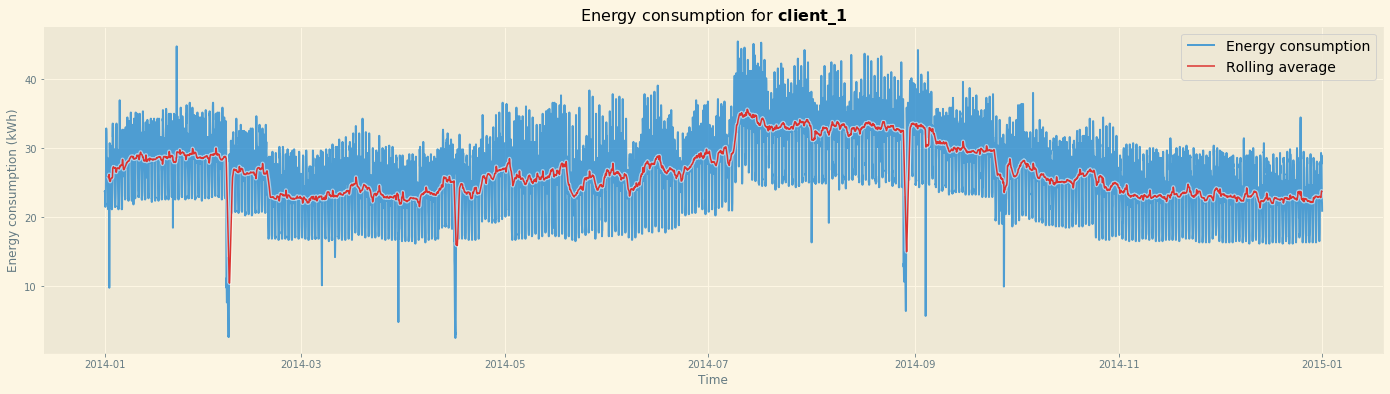

In [6]:
client_df = hourly_df[hourly_df['client_id'] == 'client_1']
daily_rolling_average = client_df['energy'].rolling(window=24).mean()

fig = plt.figure(figsize=(24,6))
plt.plot(client_df['energy'], alpha=0.8, label='Energy consumption')

# Adding daily rolling average:
plt.plot(daily_rolling_average.index, daily_rolling_average, alpha=0.5, color='white', linewidth=4)
plt.plot(daily_rolling_average.index, daily_rolling_average, color=colors[5], linewidth=1.5, label='Rolling average')

plt.title(r'Energy consumption for $\bf{client\_1}$', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Energy consumption (kWh)')
plt.legend(fontsize=14)
plt.show()

In [7]:
print(np.min(hourly_df.index))
print(np.max(hourly_df.index))

2014-01-01 01:00:00
2015-01-01 00:00:00


The dataset happens to span January 01, 2014 to January 01, 2015. We will use the following train test split:

* Training start: 2014-01-01 01:00:00
* Training end: 2014-09-30 23:00:00
* Testing start: 2014-10-01 00:00:00
* Testing end: 2015-01-01 00:00:00

Let's store these two ranges in different CSV files:

In [8]:
training_start = pd.to_datetime('2014-01-01 01:00:00')
training_end   = pd.to_datetime('2014-09-30 23:00:00')
testing_start  = pd.to_datetime('2014-10-01 00:00:00')
testing_end    = pd.to_datetime('2015-01-01 00:00:00')

In [9]:
training_df = hourly_df[training_start:training_end].reset_index()
testing_df = hourly_df[testing_start:testing_end].reset_index()

In [10]:
training_df.head()

,timestamp,energy,client_id
0,2014-01-01 01:00:00,23.648649,client_1
1,2014-01-01 01:00:00,0.000000,client_2
2,2014-01-01 01:00:00,144.817073,client_3
3,2014-01-01 01:00:00,75.000000,client_4
4,2014-01-01 01:00:00,266.369048,client_5


Now let's export them to CSV files and place them into our `data/processed` folder: Amazon Forecast expects your CSV file to not include any header or index:

In [11]:
training_df.to_csv(f"{PROCESSED_DATA}/train.csv", header=False, index=False)
testing_df.to_csv(f"{PROCESSED_DATA}/test.csv", header=False, index=False)

In [12]:
!ls -lh $PROCESSED_DATA/

total 4.0M
-rw-rw-r-- 1 ec2-user ec2-user  1.5K Dec  3 04:50 hospitality_test.csv
-rw-rw-r-- 1 ec2-user ec2-user   16K Dec  3 04:50 hospitality_train.csv
-rw-rw-r-- 1 ec2-user ec2-user 1021K Dec  3 07:25 test.csv
-rw-rw-r-- 1 ec2-user ec2-user  3.0M Dec  3 07:25 train.csv


At this time the data is ready to be sent to S3 where Forecast will use it later. The following cells will upload the data to S3.

In [13]:
KEY = f'{PREFIX}/train.csv'
boto3.Session().resource('s3').Bucket(BUCKET).Object(KEY).upload_file(f'{PROCESSED_DATA}/train.csv')

## Creating the Dataset Group and Dataset <a class="anchor" id="dataset"></a>

In Amazon Forecast , a dataset is a collection of file(s) which contain data that is relevant for a forecasting task. A dataset must conform to a schema provided by Amazon Forecast. 

More details about `Domain` and dataset type can be found on the [documentation](https://docs.aws.amazon.com/forecast/latest/dg/howitworks-domains-ds-types.html) . For this example, we are using [CUSTOM](https://docs.aws.amazon.com/forecast/latest/dg/custom-domain.html) domain with 3 required attributes `timestamp`, `target_value` and `item_id`.

It is important to also convey how Amazon Forecast can understand your time series information. The cell immediately below does that, the next one configures your variable names for the Project, DatasetGroup, and Dataset.

In [14]:
DATASET_FREQUENCY = "H" 
TIMESTAMP_FORMAT = "yyyy-MM-dd hh:mm:ss"

In [15]:
project = 'energy_consumption_forecast'
datasetName = project + '_ds'
datasetGroupName = project + '_dsg'
s3DataPath = "s3://" + BUCKET + "/" + KEY

### Create the Dataset Group

In [16]:
# Let's try to create a dataset group:
try:
    create_dataset_group_response = forecast.create_dataset_group(
        DatasetGroupName=datasetGroupName,
        Domain="CUSTOM",
    )
    datasetGroupArn = create_dataset_group_response['DatasetGroupArn']
    
except Exception as e:
    error_code = e.response['Error']['Code']
    
    # If the dataset group already exists, we get its ARN:
    if (error_code == 'ResourceAlreadyExistsException'):
        print('A dataset group with this name already exists, you can use it to create and ingest new datasets')
        
        # List all the existing dataset groups:
        forecast_dsg_list = forecast.list_dataset_groups()

        # Loop through all the Forecast dataset groups:
        for dsg in forecast_dsg_list['DatasetGroups']:
            # Get the project name (the string after the first delimiter in the ARN)
            dsg_name = dsg['DatasetGroupArn'].split('/')[1]

            # Once we find it, we store the ARN and break out of the loop:
            if (dsg_name == datasetGroupName):
                datasetGroupArn = dsg['DatasetGroupArn']
                break
                
    else:
        raise
        
print(f'- Dataset group name: {datasetGroupName}')
print(f'- Dataset group ARN: {datasetGroupArn}')

If we browse to the console, we will see a new DatasetGroup has been created:

![Dataset Group](pictures/api-dataset-group.png)

We can also use the API to get the metadata associated to this object:

In [17]:
forecast.describe_dataset_group(DatasetGroupArn=datasetGroupArn)

{'DatasetGroupName': 'energy_consumption_forecast_dsg',
 'DatasetGroupArn': 'arn:aws:forecast:eu-west-1:123031033346:dataset-group/energy_consumption_forecast_dsg',
 'DatasetArns': [],
 'Domain': 'CUSTOM',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2020, 12, 3, 7, 25, 46, 427000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2020, 12, 3, 7, 25, 46, 427000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '48fa5624-9a1b-456a-a018-d52c8185568b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 03 Dec 2020 07:25:45 GMT',
   'x-amzn-requestid': '48fa5624-9a1b-456a-a018-d52c8185568b',
   'content-length': '285',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

### Create the Dataset

Let's now define the schema: valid values for AttributeType are `string`, `integer`, `float` or `timestamp`:

In [18]:
schema = {
   "Attributes": [
      { "AttributeName": "timestamp",    "AttributeType": "timestamp" },
      { "AttributeName": "target_value", "AttributeType": "float"     },
      { "AttributeName": "item_id",      "AttributeType": "string"    }
   ]
}

Note that we are using the **same order** than the columns of the training dataset uploaded earlier: here, our `target_value` is the `energy` field and the `item_id` is the `client_id` field:

In [19]:
training_df.head()

,timestamp,energy,client_id
0,2014-01-01 01:00:00,23.648649,client_1
1,2014-01-01 01:00:00,0.000000,client_2
2,2014-01-01 01:00:00,144.817073,client_3
3,2014-01-01 01:00:00,75.000000,client_4
4,2014-01-01 01:00:00,266.369048,client_5


In [20]:
try:
    response = forecast.create_dataset(
        Domain='CUSTOM',
        DatasetType='TARGET_TIME_SERIES',
        DatasetName=datasetName,
        DataFrequency=DATASET_FREQUENCY, 
        Schema=schema
    )
    datasetArn = response['DatasetArn']
    
except Exception as e:
    error_code = e.response['Error']['Code']

    # If the dataset group already exists, we get its ARN:
    if (error_code == 'ResourceAlreadyExistsException'):
        print('A dataset with this name already exists, you can use it to ingest new data into it:')
        
        # List all the existing datasets:
        forecast_ds_list = forecast.list_datasets()

        # Loop through all the Forecast datasets:
        for ds in forecast_ds_list['Datasets']:
            # Get the project name (the string after the first delimiter in the ARN)
            ds_name = ds['DatasetArn'].split('/')[1]

            # Once we find it, we store the ARN and break out of the loop:
            if (ds_name == datasetName):
                datasetArn = ds['DatasetArn']
                break
                
    else:
        raise
        
print(f'- Dataset name: {datasetName}')
print(f'- Dataset ARN: {datasetArn}')

We can also use the API to get the metadata associated to this object: we can confirm that this is a target time series and that its frequency is hourly which is consistent with the training set we uploaded:

In [21]:
forecast.describe_dataset(DatasetArn=datasetArn)

{'DatasetArn': 'arn:aws:forecast:eu-west-1:123031033346:dataset/energy_consumption_forecast_ds',
 'DatasetName': 'energy_consumption_forecast_ds',
 'Domain': 'CUSTOM',
 'DatasetType': 'TARGET_TIME_SERIES',
 'DataFrequency': 'H',
 'Schema': {'Attributes': [{'AttributeName': 'timestamp',
    'AttributeType': 'timestamp'},
   {'AttributeName': 'target_value', 'AttributeType': 'float'},
   {'AttributeName': 'item_id', 'AttributeType': 'string'}]},
 'EncryptionConfig': {},
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2020, 12, 3, 7, 25, 46, 662000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2020, 12, 3, 7, 25, 46, 662000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '0461a25a-6cc8-48f6-8784-5b1dbbb91188',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 03 Dec 2020 07:25:46 GMT',
   'x-amzn-requestid': '0461a25a-6cc8-48f6-8784-5b1dbbb91188',
   'content-length': '521',
   'connection': 'keep-aliv

### Add Dataset to Dataset Group

In [22]:
forecast.update_dataset_group(DatasetGroupArn=datasetGroupArn, DatasetArns=[datasetArn])

{'ResponseMetadata': {'RequestId': '9692a026-1245-418f-8a5d-63ab8fa886e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 03 Dec 2020 07:25:45 GMT',
   'x-amzn-requestid': '9692a026-1245-418f-8a5d-63ab8fa886e8',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

If we browse to the console, we will see a new dataset is now attached to our dataset group. Its status is **active** but the latest import status mentions **Not uploaded**:

![Datasets](pictures/api-datasets.png)

### Create IAM Role for Forecast

Like many AWS services, Forecast will need to assume an IAM role in order to interact with your S3 resources securely. In this sample notebooks, we use the `get_or_create_iam_role()` utility function to create an IAM role:

In [23]:
def get_or_create_iam_role(role_name):
    iam = boto3.client("iam")

    assume_role_policy_document = {
        "Version": "2012-10-17",
        "Statement": [
            {
              "Effect": "Allow",
              "Principal": {
                "Service": "forecast.amazonaws.com"
              },
              "Action": "sts:AssumeRole"
            }
        ]
    }

    try:
        create_role_response = iam.create_role(
            RoleName = role_name,
            AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
        )
        role_arn = create_role_response["Role"]["Arn"]
        print("Created", role_arn)
        
    except iam.exceptions.EntityAlreadyExistsException:
        print("The role " + role_name + " exists, ignore to create it")
        role_arn = boto3.resource('iam').Role(role_name).arn

    print("Attaching policies")

    iam.attach_role_policy(
        RoleName = role_name,
        PolicyArn = "arn:aws:iam::aws:policy/AmazonForecastFullAccess"
    )

    iam.attach_role_policy(
        RoleName=role_name,
        PolicyArn='arn:aws:iam::aws:policy/AmazonS3FullAccess',
    )

    print("Waiting for a minute to allow IAM role policy attachment to propagate")
    time.sleep(60)

    print("Done.")
    return role_arn

In [24]:
# Create the role to provide to Amazon Forecast.
role_name = "ForecastNotebookRole-EnergyConsumptionPrediction"
role_arn = get_or_create_iam_role(role_name=role_name)

Created arn:aws:iam::123031033346:role/ForecastNotebookRole-EnergyConsumptionPrediction
Attaching policies
Waiting for a minute to allow IAM role policy attachment to propagate
Done.


### Create Data Import Job


Now that Forecast knows how to understand the CSV we are providing, the next step is to import the data from S3 into Amazon Forecast.

In [25]:
datasetImportJobName = 'EP_DSIMPORT_JOB_TARGET'
ds_import_job_response = forecast.create_dataset_import_job(
    DatasetImportJobName=datasetImportJobName,
    DatasetArn=datasetArn,
    DataSource= {
        "S3Config" : {
            "Path": s3DataPath,
            "RoleArn": role_arn
        }
    },
    TimestampFormat=TIMESTAMP_FORMAT
)

In [26]:
ds_import_job_arn=ds_import_job_response['DatasetImportJobArn']
print(ds_import_job_arn)

arn:aws:forecast:eu-west-1:123031033346:dataset-import-job/energy_consumption_forecast_ds/EP_DSIMPORT_JOB_TARGET


Check the status of dataset, when the status change from **CREATE_IN_PROGRESS** to **ACTIVE**, we can continue to next steps. Depending on the data size. It can take 10 mins to be **ACTIVE**. This process will take 5 to 10 minutes.

In [ ]:
while True:
    status = forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)['Status']
    print(status)
    
    if status in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(60)

print(status)

CREATE_PENDING
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS


In [ ]:
forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)

At this point you have successfully imported your data into Amazon Forecast and now it is time to get started to build your first model. The import status now mentions **Active**:

![Datasets](pictures/api-datasets-active.png)

# Building a predictor
---

## Create a Predictor

Your data was imported to be used by Amazon Forecast, here we will once again define our dataset information and then start building a model (or **predictor** in Amazon Forecast own words).

`Forecast horizon` is the number of time points to predict in the future. For weekly data, a value of 12 means 12 weeks. Our example is hourly data, we would like to forecast what happens the next day, so we can set this value to 24 (meaning 24 hours).

Every Amazon Forecast predictor uses an **algorithm** to train a model, then uses the **trained model** to make a **forecast** using an input dataset group. To help you get started, Amazon Forecast provides the following predefined algorithms:

* CNN-QR: `arn:aws:forecast:::algorithm/CNN-QR`
* DeepAR+: `arn:aws:forecast:::algorithm/Deep_AR_Plus`
* Prophet: `arn:aws:forecast:::algorithm/Prophet`
* Exponential Smoothing (ETS): `arn:aws:forecast:::algorithm/ETS`
* Autoregressive Integrated Moving Average (ARIMA): `arn:aws:forecast:::algorithm/ARIMA`
* Non-Parametric Time Series (NPTS): `arn:aws:forecast:::algorithm/NPTS`

For more details about the different algorithms and how to choose them, check the [documentation](https://docs.aws.amazon.com/forecast/latest/dg/aws-forecast-choosing-recipes.html).

**Amazon Forecast DeepAR+** is a supervised learning algorithm for forecasting scalar (one-dimensional) time series using recurrent neural networks (RNNs). Classical forecasting methods, such as *autoregressive integrated moving average* (ARIMA) or *exponential smoothing* (ETS), fit a single model to each individual time series, and then use that model to extrapolate the time series into the future.

In many applications, however, you have many similar time series across a set of cross-sectional units. These time-series can relate to different clients, products, server loads, or requests for web pages. In this case, it can be beneficial to train a single model jointly over all of the time series. DeepAR+ takes this approach. **When your dataset contains hundreds of feature time series, the DeepAR+ algorithm outperforms the standard ARIMA and ETS methods**. You can also use the trained model for generating forecasts for new time series that are similar to the ones it has been trained on (**cold start** for never-seen before signals).

In the case of our energy dataset, we only have 10 different households:

In [ ]:
len(training_df['client_id'].unique())

Given this small number of time series, we will select ARIMA, which we will do in the following cell:

In [ ]:
predictorName= project + '_arima'
forecastHorizon = 24
algorithmArn = 'arn:aws:forecast:::algorithm/ARIMA'

We can now create our **Predictor** by training a model on the data provided to Amazon Forecast. In the background, Amazon Forecast cut the most recent data to build a train / validation split. The model is trained on the new training split and the performance metrics are evaluated against the new validation split.

In [ ]:
try:
    create_predictor_response = forecast.create_predictor(
        PredictorName = predictorName, 
        AlgorithmArn = algorithmArn,
        ForecastHorizon = forecastHorizon,
        PerformAutoML = False,
        PerformHPO = False,
        EvaluationParameters= {
            "NumberOfBacktestWindows": 1, 
            "BackTestWindowOffset": 24
        }, 
        InputDataConfig = {"DatasetGroupArn": datasetGroupArn},
        FeaturizationConfig = {
            "ForecastFrequency": "H", 
            "Featurizations": [{
                "AttributeName": "target_value", 
                "FeaturizationPipeline": [{
                    "FeaturizationMethodName": "filling", 
                    "FeaturizationMethodParameters": {
                        "frontfill": "none", 
                        "middlefill": "zero", 
                        "backfill": "zero"
                    }
                }]
            }]
        }
    )

    predictor_arn = create_predictor_response['PredictorArn']
    
except Exception as e:
    error_code = e.response['Error']['Code']

    # If the predictor already exists, we get its ARN:
    if (error_code == 'ResourceAlreadyExistsException'):
        print('A predictor with this name already exists, you can query it to check its status or request a forecast:')
        
        # List all the existing predictors:
        forecast_pred_list = forecast.list_predictors()

        # Loop through all the Forecast predictors:
        for predictor in forecast_pred_list['Predictors']:
            # Get the project name (the string after the first delimiter in the ARN)
            predictor_name = predictor['PredictorArn'].split('/')[1]

            # Once we find it, we store the ARN and break out of the loop:
            if (predictor_name == predictorName):
                predictor_arn = predictor['PredictorArn']
                break
                   
    else:
        raise
        
print(f'- Predictor name: {predictorName}')
print(f'- Predictor ARN: {predictor_arn}')

Our predictor (model) is now training as we can see in the console:

![Datasets](pictures/api-predictor-training.png)

Check the status of the predictor: when the status change from **CREATE_IN_PROGRESS** to **ACTIVE**, we can continue to next steps. Depending on data size, model selection and hyper parameters，it can take 10 mins to more than one hour to be **ACTIVE**. This is  still a training task so for this model, it will take around 15 minutes:

In [ ]:
while True:
    status = forecast.describe_predictor(PredictorArn=predictor_arn)['Status']
    print(status)
    
    if status in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(60)

print(status)

### Get Error Metrics

Our predictor is now **active** and we can see in the console the associated performance (WAPE and RMSE metric computed on the validation dataset). You can click on the predictor name to see more details or to download the backtest results for instance:

![Datasets](pictures/api-predictor-active.png)

We can also collect these metrics through the API:

In [43]:
forecast.get_accuracy_metrics(PredictorArn=predictor_arn)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/ARIMA',
   'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 13.508326497982193,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.04936248161035917},
       {'Quantile': 0.5, 'LossValue': 0.10099251983836498},
       {'Quantile': 0.1, 'LossValue': 0.052798129455369464}],
      'ErrorMetrics': [{'ForecastType': 'mean',
        'WAPE': 0.10099251983836498,
        'RMSE': 13.508326497982193}]}},
    {'TestWindowStart': datetime.datetime(2014, 9, 30, 0, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2014, 10, 1, 0, 0, tzinfo=tzlocal()),
     'ItemCount': 10,
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 13.508326497982193,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.04936248161035917},
       {'Quantile': 0.5, 'LossValue': 0.10099251983836496},
       {'Quantile': 0.1, 'LossValue': 0.052798129455369464}],
  

## Create a Forecast

Now we can create a forecast using the predictor that was trained. During the **first forecast creation**, Amazon Forecast **retrains** a model on the entire dataset: this time, it doesn't split the training set in train / validation, it uses your whole training data to train a model for every item_id.

Once the new model is trained, it is hosted (similarly to a SageMaker Endpoint, it provisions the necessary resources to host the trained model so that it can serve predictions) so that it can perform inference. This `CreateForecast` operation creates a forecast for every item (item_id) in the dataset group that was used to train the predictor. After a forecast is created, you can query the forecast or export it to an Amazon S3 bucket.

In [ ]:
forecastName = project + '_arima_forecast'

In [ ]:
try:
    create_forecast_response = forecast.create_forecast(
        ForecastName=forecastName,
        PredictorArn=predictor_arn
    )
    forecast_arn = create_forecast_response['ForecastArn']
    
except Exception as e:
    error_code = e.response['Error']['Code']

    # If the predictor already exists, we get its ARN:
    if (error_code == 'ResourceAlreadyExistsException'):
        print('A forecast with this name already exists, you can use it to obtain a prediction:')
        
        # List all the existing predictors:
        forecast_fc_list = forecast.list_forecasts()

        # Loop through all the Forecast forecasts:
        for fc in forecast_fc_list['Forecasts']:
            # Get the project name (the string after the first delimiter in the ARN)
            fc_name = fc['ForecastArn'].split('/')[1]

            # Once we find it, we store the ARN and break out of the loop:
            if (fc_name == forecastName):
                forecast_arn = fc['ForecastArn']
                break
                
    else:
        raise
        
print(f'- Forecast name: {forecastName}')
print(f'- Forecast ARN: {forecast_arn}')

Our forecast is now provisioning as we can see in the console:

![Datasets](pictures/api-forecast-provisioning.png)

Check the status of the forecast: when the status change from **CREATE_IN_PROGRESS** to **ACTIVE**, we can continue to next steps. Depending on model size (that depends on algorithm selection) and number of items，it can take 10 mins to more than one hour to be **ACTIVE**. For this model, it will take 15-20 minutes for the first forecast:

In [ ]:
while True:
    status = forecast.describe_forecast(ForecastArn=forecast_arn)['Status']
    print(status)
    
    if status in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(60)

print(status)

Our forecast has finished training on the whole dataset and is now ready to be queried:

![Datasets](pictures/api-forecast-active.png)

# Evaluating your forecast
---

## Get a forecast (obtaining a prediction)
Once created, the forecast results are ready to be viewed. To query a forecast, you can specify dates (use the ISO 8601 format for this: `yyyy-MM-dd'T'HH:mm:ss`. For example, `2015-01-01T08:00:00`) or the `query_forecast` will send back the whole forecast horizon. Our forecast horizon is 24 hours, so that will be 24 data points for this example:

In [44]:
client_id = 'client_1'

print(forecast_arn)
print()
forecastResponse = forecastquery.query_forecast(
    ForecastArn=forecast_arn,
    Filters={'item_id': client_id}
)
print(forecastResponse)

arn:aws:forecast:eu-west-1:123031033346:forecast/energy_consumption_forecast_arima_forecast

{'Forecast': {'Predictions': {'p10': [{'Timestamp': '2014-10-01T00:00:00', 'Value': 21.8402156829834}, {'Timestamp': '2014-10-01T01:00:00', 'Value': 18.716354370117188}, {'Timestamp': '2014-10-01T02:00:00', 'Value': 16.825145721435547}, {'Timestamp': '2014-10-01T03:00:00', 'Value': 14.990082740783691}, {'Timestamp': '2014-10-01T04:00:00', 'Value': 13.274307250976562}, {'Timestamp': '2014-10-01T05:00:00', 'Value': 14.874940872192383}, {'Timestamp': '2014-10-01T06:00:00', 'Value': 17.804637908935547}, {'Timestamp': '2014-10-01T07:00:00', 'Value': 21.146377563476562}, {'Timestamp': '2014-10-01T08:00:00', 'Value': 24.23131561279297}, {'Timestamp': '2014-10-01T09:00:00', 'Value': 24.694671630859375}, {'Timestamp': '2014-10-01T10:00:00', 'Value': 23.99750518798828}, {'Timestamp': '2014-10-01T11:00:00', 'Value': 23.321178436279297}, {'Timestamp': '2014-10-01T12:00:00', 'Value': 22.47322654724121}, {'T

## Getting the actual results

Earlier we created a file of observed values for both the training and the testing periods, we are now going to select a given date and client_id from that dataframe and are going to plot the actual consumption data for that customer. We need to reduce the data to just the day we wish to plot, which is October, 1st 2014, and we only grab the items for household `client_1`:

In [ ]:
actual_train_df = pd.read_csv(f'{PROCESSED_DATA}/train.csv', names=['timestamp','actual','item_id'], parse_dates=[0])
actual_train_df = actual_train_df[(actual_train_df['item_id'] == client_id)]

testing_start  = pd.to_datetime('2014-10-01 00:00:00')
testing_end    = pd.to_datetime('2014-10-01 23:00:00')
actual_test_df = pd.read_csv(f'{PROCESSED_DATA}/test.csv', names=['timestamp','actual','item_id'], parse_dates=[0])
actual_train_df = actual_train_df.append(actual_test_df.iloc[0], ignore_index=True)
actual_train_df = actual_train_df.set_index('timestamp')
actual_test_df = actual_test_df.set_index('timestamp')
actual_test_df = actual_test_df[testing_start:testing_end]
actual_test_df = actual_test_df[(actual_test_df['item_id'] == client_id)]

actual_test_df.tail()

## Post-processing the prediction

Next we need to convert the JSON response from the Predictor to a dataframe that we can plot. The cell below generates a dataframe for p10, p50 and p90. `p50` gives the prediction median while `p90 - p10` gives the 80% confidence interval.

In [ ]:
predictions_df = dict()
for percentile in ['p10', 'p50', 'p90']:
    predictions_df.update({percentile: pd.DataFrame.from_dict(forecastResponse['Forecast']['Predictions'][percentile])})
    predictions_df[percentile]['Timestamp'] = pd.to_datetime(predictions_df[percentile]['Timestamp'])
    predictions_df[percentile].columns = ['Timestamp', percentile]

In [ ]:
results_df = pd.merge(actual_test_df.reset_index(), predictions_df['p10'], how='inner', left_on=['timestamp'], right_on='Timestamp')

for percentile in ['p50', 'p90']:
    results_df = pd.merge(results_df, predictions_df[percentile], how='inner', left_on=['timestamp'], right_on='Timestamp')

results_df = results_df[['timestamp', 'actual', 'p10', 'p50', 'p90']]
results_df = results_df.set_index('timestamp')
results_df.head()

## Comparing the prediction to actual results

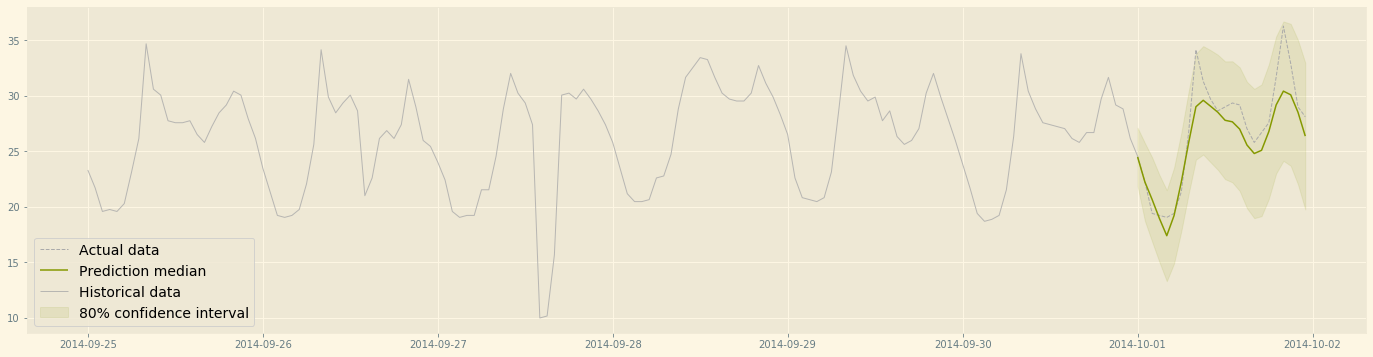

In [42]:
# First, plot the actual data during the evaluation period:
fig = plt.figure(figsize=(24,6))
plt.plot(results_df['actual'], label='Actual data', linewidth=1, color=colors[5], linestyle='--', alpha=0.5)
plt.plot(results_df['actual'], linewidth=5, color=colors[4], alpha=0.1)

# Next, plot the prediction enveloppe and the median value predicted:
# plt.plot(results_df['p50'], label='Prediction median', color=colors[2], linewidth=1.5)
p10 = results_df['p10']
p90 = results_df['p90']
plt.fill_between(p10.index, p10, p90, color=colors[2], alpha=0.1, label='80% confidence interval')
plt.plot(results_df['p10'], label='Confidence interval lower bound', color=colors[2], linewidth=0.5, alpha=0.5)

# And then, add the training period for this item_id:
start = pd.to_datetime('2014-09-25 00:00:00')
end   = pd.to_datetime('2014-10-02 01:00:00')
plt.plot(actual_train_df.loc[start:end, 'actual'], label='Historical data', linewidth=1, color='#AAAAAA', alpha=0.8)

# Show the plot with a legend
plt.legend(fontsize=14)
plt.show()

# Conclusion
---

## New forecast generation strategy
To get a new forecast: 
* Wait 24 hours and update dataset with a real data. Create new forecast without model retraining.
* Train a predictor with a longer forecast horizon
* Create forecast and update dataset with its data. Create new forecast without model retraining.

## Cleanup
### Helper function to delete Forecast resources

In [ ]:
def wait_till_delete(callback, check_time=5, timeout=None):
    elapsed_time = 0
    while timeout is None or elapsed_time < timeout:
        try:
            out = callback()
            
        except botocore.exceptions.ClientError as e:
            # When given the resource not found exception, deletion has occured
            if e.response['Error']['Code'] == 'ResourceNotFoundException':
                print('Delete successful')
                return
            
            else:
                raise
                
        time.sleep(check_time)
        elapsed_time += check_time

    raise TimeoutError('Forecast resource deletion timed-out.')

### Defining the things to cleanup

The cells below will delete the items that were created in this notebook one at a time until all items that were created have been removed.

In [ ]:
print('Delete the Forecast:     ', end='')
wait_till_delete(lambda: forecast.delete_forecast(ForecastArn=forecast_arn))

print('Delete the Predictor:    ', end='')
wait_till_delete(lambda: forecast.delete_predictor(PredictorArn=predictor_arn))

print('Delete the Import:       ', end='')
wait_till_delete(lambda: forecast.delete_dataset_import_job(DatasetImportJobArn=ds_import_job_arn))

print('Delete the Dataset:      ', end='')
wait_till_delete(lambda: forecast.delete_dataset(DatasetArn=datasetArn))

print('Delete the DatasetGroup: ', end='')
wait_till_delete(lambda: forecast.delete_dataset_group(DatasetGroupArn=datasetGroupArn))

In [ ]:
# Delete your file in S3
boto3.Session().resource('s3').Bucket(BUCKET).Object(KEY).delete()

### IAM role and policy cleanup

The very last step in the notebooks is to remove the policies that were attached to a role and then to delete it. No changes should need to be made here, just execute the cell.

In [ ]:
iam = boto3.client("iam")
iam.detach_role_policy( PolicyArn = "arn:aws:iam::aws:policy/AmazonS3FullAccess", RoleName = role_name )
iam.detach_role_policy( PolicyArn = "arn:aws:iam::aws:policy/AmazonForecastFullAccess", RoleName = role_name )
iam.delete_role(RoleName=role_name)